1/1 [==============================] - 0s 35ms/step
episode: 0 score: 22.0
1/1 [==============================] - 0s 23ms/step
episode: 1 score: 25.0
1/1 [==============================] - 0s 32ms/step
episode: 2 score: 47.0
1/1 [==============================] - 0s 30ms/step
episode: 3 score: 20.0
1/1 [==============================] - 0s 33ms/step
episode: 4 score: 59.0
1/1 [==============================] - 0s 30ms/step
episode: 5 score: 42.0
1/1 [==============================] - 0s 26ms/step
episode: 6 score: 23.0
1/1 [==============================] - 0s 29ms/step
episode: 7 score: 73.0
1/1 [==============================] - 0s 94ms/step
episode: 8 score: 11.0
1/1 [==============================] - 0s 31ms/step
episode: 9 score: 9.0
1/1 [==============================] - 0s 27ms/step
episode: 10 score: 34.0
1/1 [==============================] - 0s 38ms/step
episode: 11 score: 40.0
1/1 [==============================] - 0s 24ms/step
episode: 12 score: 19.0
1/1 [==================

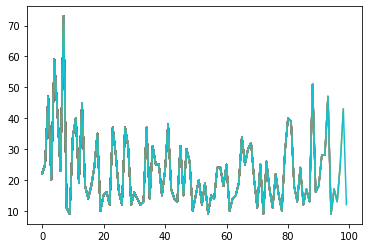

In [26]:
import gym
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

class A2C:
    def __init__(self, environment, state_size, action_size, discount_factor = 0.99, actor_learning_rate = 0.001, critic_learning_rate= 0.005, value_size = 1, actor_entropy = 0.001):
        self.env = environment
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = discount_factor
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.value_size = value_size
        self.actor_entropy = actor_entropy

        self.actor = Actor(self.state_size, self.action_size, self.actor_learning_rate)
        self.actor_network = self.actor.create_actor_network()
        self.critic = Critic(self.state_size, self.value_size, self.critic_learning_rate)
        self.critic_network = self.critic.create_critic_network()

    def training_loop(self, number_of_episodes):
        scores, episodes = [], []
        for e in range(number_of_episodes):
            done = False
            score = 0
            state = self.env.reset()
            state = np.reshape(state,[1,self.state_size])
            while not done:
                # Check if we want to render
                #if self.agent.render:
                #    env.render()
                #get action:
                policy = self.actor_network.predict(state,batch_size=1).flatten()
                action = np.random.choice(self.action_size, 1, p=policy)[0]
                next_state, reward, done, info = self.env.step(action)
                next_state = np.reshape(next_state,[1,self.state_size])
                # Give immediate penalty for an action that terminates the episode immediately, Since we want to maximize the time
                # Note that the max for the cartpole is 499 and it will reset, otherwise we keep the current score if it is not yet done, and if it ended we give a -100 reward
                reward = reward if not done or score == 499 else -100
                # We now train the model based on the results of our action taken
                self.train_model(state,action,reward,next_state,done)
                score += reward
                state = next_state

                if done:
                    score = score if score == 500.0 else score +100
                    scores.append(score)
                    episodes.append(e)
                    plt.plot(episodes,scores)
                    #pylab.savefig("./save_graph/A2C-CartPole.png")
                    #if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #    sys.exit()
            if e % 1 ==0: #%50
                #agent.actor.save_weights("./save_model/cartpole_actor.h5")
                #agent.critic.save_weights("./save_model/cartpole_critic.h5")
                print("episode: {} score: {}".format(e,score))
    
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1,self.value_size)) # Initialize the policy targets matrix
        advantages = np.zeros((1,self.action_size)) # Initialize the advantages matrix

        

        optimizer_actor = tf.keras.optimizers.Adam(learning_rate = self.actor_learning_rate)
        optimizer_critic = tf.keras.optimizers.Adam(learning_rate = self.critic_learning_rate)
       
        with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2:
            value = self.critic_network(state)[0] # Get value for this state
            next_value = self.critic_network(next_state)[0] # Get value for the next state

            logits = self.actor_network(state)
            logit = logits[0][action]
            
            # update the advantages and value tables if done
            advantages[0][action] = reward + (1.0 - done) * self.discount_factor*(next_value) - value # If not yet done, then simply update for the current step.
            target[0][0] = reward + (1.0 - done) * self.discount_factor*next_value
            

            mse = tf.keras.losses.MeanSquaredError()
            critic_loss = mse(reward, value)
            #print(critic_loss)
            #action = np.expand_dims([action], axis = 0)
            action = tf.cast([action], tf.int32)
            actor_loss = - tf.keras.losses.sparse_categorical_crossentropy(action, logits, from_logits=False) #eigentlich True
            #print(actor_loss)
            
            loss = [actor_loss, critic_loss]
            #print(loss)
            #action = tf.cast(action, tf.int32)
            #print(action)
            #policy_loss = tf.keras.losses.CategoricalCrossentropy(action, logit, from_logits=True, sample_weight=advantages)
            #entropy_loss = tf.keras.categorical_crossentropy(logit, logit, from_logits=True)
            #actor_loss = policy_loss - self.actor_entropy * entropy_loss

        actor_gradient = tape_1.gradient(actor_loss, self.actor_network.trainable_variables)
        critic_gradient = tape_2.gradient(critic_loss, self.critic_network.trainable_variables)

        #print(len(gradient))
        #gradients = gradients[1]
        optimizer_critic.apply_gradients(zip(critic_gradient, self.critic_network.trainable_variables))

        optimizer_actor.apply_gradients((zip(actor_gradient, self.actor_network.trainable_variables)))

        
                


        
        


class Actor:
    def __init__(self, state_size, action_size, learning_rate):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

    def create_actor_network(self):
        actor_input = tf.keras.Input(shape=self.state_size) # Define our model
        x = Dense(24, activation='relu', kernel_initializer='he_uniform')(actor_input)
        actor_output = Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform')(x)
        #actor_network.summary()
        #actor_network.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = self.learning_rate))
        actor_network = tf.keras.Model(actor_input, actor_output, name = "Actor")
        return actor_network

        

    

class Critic:
    def __init__(self, state_size, value_size, learning_rate):
        self.state_size = state_size
        self.value_size = value_size
        self.learning_rate = learning_rate
    
    def create_critic_network(self):
        critic_input = tf.keras.Input(shape=self.state_size) # Define our model
        x = Dense(24, activation='relu', kernel_initializer='he_uniform')(critic_input)
        critic_output = Dense(self.value_size, activation='linear', kernel_initializer='he_uniform')(x)
        #critic.compile(loss = 'mse', optimizer= Adam(lr=self.critic_lr))# Loss is MSE since we want to give out a value and not a probability.        critic_network = tf.keras.Model(critic_input, critic_output)
        critic_network = tf.keras.Model(critic_input, critic_output, name = "Critic")
        #critic_network.summary()
        return critic_network



environment = gym.make('CartPole-v1')
environment.reset()
state_size = environment.observation_space.shape[0]
# print(environment.action_space) = Discrete(2)
# funktioniert nicht, also hardcoden
#action_size = environment.action_space.shape[0]
action_size = 2
a2c = A2C(environment,state_size,action_size)

a2c.training_loop(100)
